In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from sklearn.preprocessing import MinMaxScaler

2024-09-23 23:26:16.293321: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-23 23:26:16.302107: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-23 23:26:16.312373: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-23 23:26:16.315440: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-23 23:26:16.322933: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# # Preprocessing
# tnx = pd.read_csv("/home/malikcyrus/experiment_ii/anomaly_detection/illicit_transactions.csv")
# df = pd.read_csv("/home/malikcyrus/crypto-multimodal-reputability/code_analysis/known_reputable_scores.csv")
# df2 = pd.read_csv("/home/malikcyrus/crypto-multimodal-reputability/code_analysis/opcode_embeddings.csv")
# df = pd.merge(df, df2, on='address', how='left')
# tnx = tnx.merge(df.drop("is_reputable", axis=1), on='address', how='left')

# tnx = tnx[['timeWindow', 'address', 'value_sum', 'value_mean', 'gas_sum',
#        'gas_mean', 'gasPrice_sum', 'gasPrice_mean', 'isError_sum',
#        'unique_received_from', '0', '1',
#        '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14',
#        '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26',
#        '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38',
#        '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', 'is_reputable',]]

# tnx.to_csv("illicit_tnx_opcode.csv", index=False)

In [2]:
df_reputable = pd.read_csv("reputable_tnx_opcode.csv")

In [3]:
# df_reputable = pd.read_csv("reputable_tnx_opcode.csv")

# Step 2: Specify the columns for which we want to remove outliers
columns_to_check = df_reputable.drop(columns=['timeWindow', 'address', 'is_reputable']).columns

# Step 3: Apply the IQR method to remove outliers for the specified columns
Q1 = df_reputable[columns_to_check].quantile(0.25)
Q3 = df_reputable[columns_to_check].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers: rows outside 1.5 * IQR
outlier_condition = ~((df_reputable[columns_to_check] < (Q1 - 1.5 * IQR)) | 
                    (df_reputable[columns_to_check] > (Q3 + 1.5 * IQR))).any(axis=1)

# Remove outliers
df_reputable_cleaned = df_reputable[outlier_condition]

# from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_reputable[df_reputable.drop(columns=['timeWindow', 'address', 'is_reputable']).columns] = scaler.fit_transform(df_reputable[df_reputable.drop(columns=['timeWindow', 'address', 'is_reputable']).columns])

sequence_lengths = df_reputable.groupby('address').size()
max_timesteps = 1206 #  int(np.percentile(sequence_lengths, 75))

In [4]:
max_timesteps = 1206

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Dropout, ZeroPadding1D
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import kerastuner as kt

# Define basic mean squared error loss
def mse(y_true, y_pred):
    return tf.keras.losses.MeanSquaredError()(y_true, y_pred)
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import kerastuner as kt
# Define the CAE model with extended hyperparameters
class CAEHyperModel(kt.HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        input_seq = Input(shape=self.input_shape)

        # Encoder
        x = Conv1D(filters=hp.Int('filters_1', min_value=16, max_value=64, step=16), 
                   kernel_size=hp.Choice('kernel_size_1', values=[3, 5]), 
                   activation=hp.Choice('activation', values=['relu', 'tanh']), 
                   padding='same',
                   kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_reg_1', min_value=0, max_value=0.1, step=0.01)))(input_seq)
        x = MaxPooling1D(pool_size=hp.Choice('pool_size_1', values=[2, 4]), padding='same')(x)
        x = Dropout(hp.Float('dropout_1', min_value=0, max_value=0.5, step=0.1))(x)
        x = Conv1D(filters=hp.Int('filters_2', min_value=8, max_value=32, step=8), 
                   kernel_size=hp.Choice('kernel_size_2', values=[3, 5]), 
                   activation=hp.Choice('activation', values=['relu', 'tanh']), 
                   padding='same',
                   kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_reg_2', min_value=0, max_value=0.1, step=0.01)))(x)
        encoded = MaxPooling1D(pool_size=hp.Choice('pool_size_2', values=[2, 4]), padding='same')(x)

        # Decoder
        x = Conv1D(filters=hp.Int('filters_2', min_value=8, max_value=32, step=8), 
                   kernel_size=hp.Choice('kernel_size_2', values=[3, 5]), 
                   activation=hp.Choice('activation', values=['relu', 'tanh']), 
                   padding='same')(encoded)
        x = UpSampling1D(size=hp.Choice('up_sampling_size_1', values=[2, 4]))(x)
        x = Dropout(hp.Float('dropout_2', min_value=0, max_value=0.5, step=0.1))(x)
        x = Conv1D(filters=hp.Int('filters_1', min_value=16, max_value=64, step=16), 
                   kernel_size=hp.Choice('kernel_size_1', values=[3, 5]), 
                   activation=hp.Choice('activation', values=['relu', 'tanh']), 
                   padding='same')(x)
        x = UpSampling1D(size=hp.Choice('up_sampling_size_2', values=[2, 4]))(x)
        
        # Adjust the final output to match the original input sequence length
        x = x[:, :max_timesteps, :]
        decoded = Conv1D(self.input_shape[1], kernel_size=3, activation='sigmoid', padding='same')(x)

        # decoded = decoded[:, :self.input_shape[0], :]  # Ensure the output has the same length as the input
        model = Model(input_seq, decoded)
        model.compile(optimizer=tf.keras.optimizers.Adam(
                          hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                      loss='mse')
        return model

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))  # Ensure the output is a float

lr_scheduler = LearningRateScheduler(scheduler)

# Data preparation
def prepare_data(df, max_timesteps):
    # Prepare data for reputable contracts
    sequences = [group[df.drop(columns=["address", "timeWindow", "is_reputable"]).columns].values
                 for _, group in df.groupby('address')]
    X = pad_sequences(sequences, maxlen=max_timesteps, dtype='float32', padding='post', truncating='post')
    return X

In [5]:
import cupy as cp 
# X = prepare_data(df_reputable, max_timesteps)
# cp.save("X_rep_1206.npy", X)
X= cp.load("X_rep_1206.npy").get()

In [4]:
import cupy as cp 
# X = prepare_data(df_reputable, max_timesteps)
# cp.save("X_ill_1206.npy", X)
X= cp.load("X_ill_1206.npy").get()

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import keras_tuner as kt
import numpy as np
# Function to perform K-Fold Cross-Validation and Batch size tuning
from sklearn.model_selection import TimeSeriesSplit

def train_and_evaluate(max_timesteps, batch_sizes=[16, 32, 64], time_based=False):
    histories = {}
    tuning_results = []  # Store tuning results

    for batch_size in batch_sizes:
        fold_no = 1
        
        # Reinitialize the split generator for each batch size
        tscv = TimeSeriesSplit(n_splits=5)
        split_generator = tscv.split(X)
        
        for train_index, val_index in split_generator:
            X_train, X_val = X[train_index], X[val_index]
            
            # Define the model
            hypermodel = CAEHyperModel(input_shape=(max_timesteps, X.shape[2]))
            tuner = kt.RandomSearch(
                hypermodel,
                objective='val_loss',
                max_trials=5,
                executions_per_trial=1,
                directory='tuner_dir',
                project_name=f'cae_tuning_opcode_tnx_{batch_size}'
            )

            # Perform hyperparameter search WITHOUT the LearningRateScheduler
            tuner.search(X_train, X_train, epochs=30, batch_size=batch_size, validation_data=(X_val, X_val))

            # Get the best hyperparameters and store them
            best_hp = tuner.oracle.get_best_trials(1)[0].hyperparameters.values
            # tuning_results.append({
            #     'batch_size': batch_size,
            #     'fold': fold_no,
            #     'best_filters_1': best_hp['filters_1'],
            #     'best_filters_2': best_hp['filters_2'],
            #     'learning_rate': best_hp['learning_rate'],
            #     'val_loss': tuner.oracle.get_best_trials(1)[0].get_best_value('val_loss') 
            # })

            best_trial = tuner.oracle.get_best_trials(1)[0]
            val_loss_history = best_trial.metrics.get_history('val_loss')
            best_val_loss = val_loss_history[-1]  # Get the last validation loss value (best)

            # Append the results including best validation loss
            tuning_results.append({
                'batch_size': batch_size,
                'fold': fold_no,
                'best_filters_1': best_hp['filters_1'],
                'best_filters_2': best_hp['filters_2'],
                'learning_rate': best_hp['learning_rate'],
                'activation': best_hp['activation'], 
                'kernel_size_1': best_hp['kernel_size_1'],
                'kernel_size_2': best_hp['kernel_size_2'],
                'l2_reg_1': best_hp['l2_reg_1'],
                'l2_reg_2': best_hp['l2_reg_2'],
                'pool_size_1': best_hp['pool_size_1'],
                'pool_size_1': best_hp['pool_size_2'],
                'dropout_1': best_hp['dropout_1'],
                'dropout_2': best_hp['dropout_2'],
                'up_sampling_size_1': best_hp['up_sampling_size_1'],
                'up_sampling_size_2': best_hp['up_sampling_size_2'],
                'val_loss': best_val_loss
            })

            # Get the best model
            best_model = tuner.get_best_models(num_models=1)[0]
            best_model.save(f"cae_tnx_opcode_{batch_size}.keras")

            # Now fit the best model with the LearningRateScheduler
            history = best_model.fit(
                X_train, X_train,
                epochs=30,
                batch_size=batch_size,
                validation_data=(X_val, X_val),
                callbacks=[lr_scheduler]  # Add the scheduler after finding the best model
            )

            # Initialize histories for the current batch size if not done already
            if batch_size not in histories:
                histories[batch_size] = {'train_loss': [], 'val_loss': []}
                
            # Collect the loss histories for the current fold
            histories[batch_size]['train_loss'].append(history.history['loss'])
            histories[batch_size]['val_loss'].append(history.history['val_loss'])
            
            fold_no += 1
    
    # Plot training and validation loss for different batch sizes
    plt.figure(figsize=(12, 6))
    for batch_size in batch_sizes:
        # Safeguard against missing data
        if batch_size in histories:
            train_loss_avg = np.mean(histories[batch_size]['train_loss'], axis=0)
            val_loss_avg = np.mean(histories[batch_size]['val_loss'], axis=0)
            
            # Create a new figure for each batch size
            plt.figure(figsize=(8, 5))
            plt.plot(train_loss_avg, label=f'Training Loss (batch={batch_size})')
            plt.plot(val_loss_avg, '--', label=f'Validation Loss (batch={batch_size})')
            
            # Set plot title and labels
            plt.title(f'Training and Validation Loss for Batch Size {batch_size}')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            
            # Show the plot
            plt.show()
    
    # Hyperparameter tuning results as a DataFrame
    tuning_df = pd.DataFrame(tuning_results)
    
    # Print the hyperparameter tuning results
    print("\nHyperparameter Tuning Results:")
    print(tuning_df)

    # Save the tuning results to a CSV for later analysis
    tuning_df.to_csv('hyperparameter_tuning_results_tnx_opcode.csv', index=False)

    return best_model, tuning_df

In [11]:
max_timesteps = 1206

Trial 5 Complete [00h 00m 01s]

Best val_loss So Far: 0.010093779303133488
Total elapsed time: 00h 00m 35s
Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 881ms/step - loss: 0.0342 - val_loss: 0.0740 - learning_rate: 0.0083
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0773 - val_loss: 0.1766 - learning_rate: 0.0083
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.1937 - val_loss: 0.1760 - learning_rate: 0.0083
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1945 - val_loss: 0.1725 - learning_rate: 0.0083
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1973 - val_loss: 0.1721 - learning_rate: 0.0083
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1878 - val_loss: 0.1715 - learning_rate: 0.0083
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.1871 - val_loss: 0.1701 - learning_rate: 0.0083
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1871 - val_loss: 0.1694 - learning_rate: 0.0083
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 

2024-09-23 20:12:37.107300: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 35813376 bytes after encountering the first element of size 35813376 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0182 - val_loss: 0.0131 - learning_rate: 0.0083
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0135 - val_loss: 0.0119 - learning_rate: 0.0083
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0108 - val_loss: 0.0076 - learning_rate: 0.0083
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0079 - val_loss: 0.0121 - learning_rate: 0.0083
Epoch 9/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0132 - val_loss: 0.0090 - learning_rate: 0.0083
Epoch 10/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0091 - val_loss: 0.0066 - learning_rate: 0.0083
Epoch 11/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0067 - val_loss: 0.0053 - learning_rate: 0.0075
Epoch 12/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0058 - val_loss: 0.0051 - learning_rate: 0.0068
Epoch 13/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0057 - val_loss: 0.0046 - learning_rate: 0.0061
Epoch 14/30
13/13 ━━━━━━━━

<Figure size 1200x600 with 0 Axes>

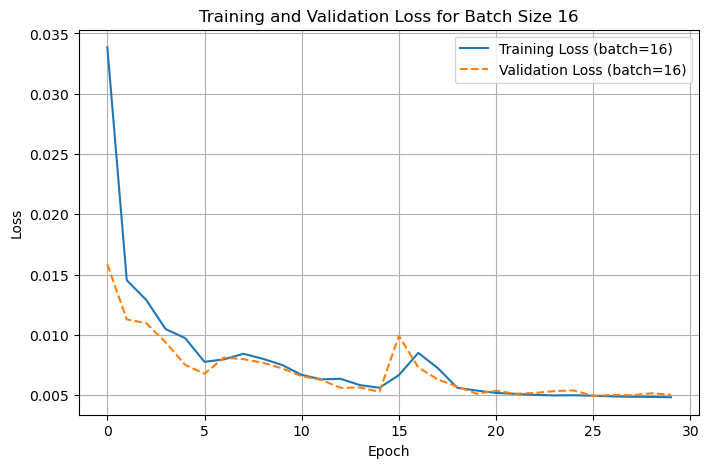

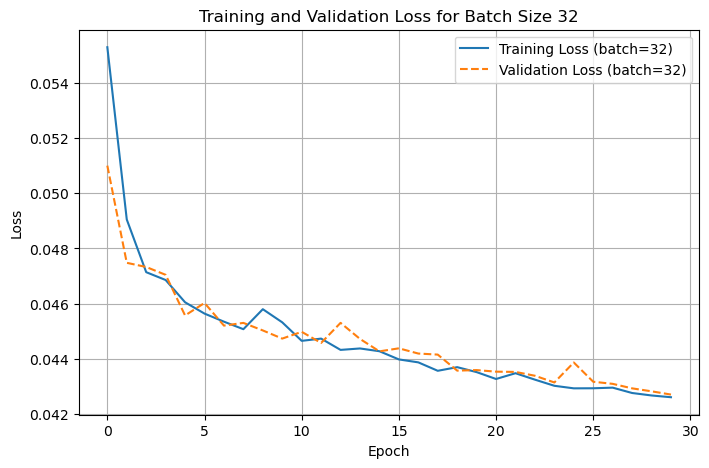

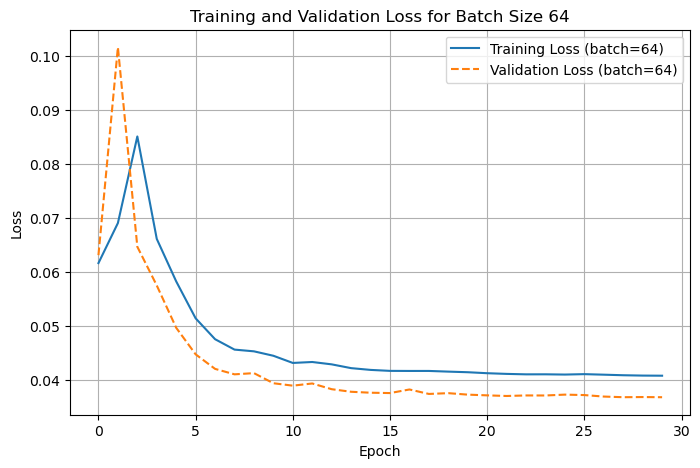


Hyperparameter Tuning Results:
    batch_size  fold  best_filters_1  best_filters_2  learning_rate  \
0           16     1              32               8       0.004871   
1           16     2              32               8       0.004871   
2           16     3              32               8       0.004871   
3           16     4              32               8       0.004871   
4           16     5              32               8       0.004871   
5           32     1              64              32       0.001279   
6           32     2              64              32       0.001279   
7           32     3              64              32       0.001279   
8           32     4              64              32       0.001279   
9           32     5              64              32       0.001279   
10          64     1              64              16       0.008290   
11          64     2              64              16       0.008290   
12          64     3              64         

In [6]:
model, tuning_df = train_and_evaluate(max_timesteps)

In [4]:
model = tf.keras.models.load_model("cae_tnx_opcode_16.keras")

I0000 00:00:1727126795.225705    8384 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727126795.241285    8384 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727126795.241337    8384 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727126795.242402    8384 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727126795.242449    8384 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [6]:
all_addresses = list(df_reputable['address'].unique())
X_all_no_label = X[:, :, :]
reconstructions = model.predict(X)
reconstructions_no_label = reconstructions[:, :, :]

# Calculate reconstruction error per transaction (average over feature dimension)
reconstruction_error_per_transaction = np.median(np.abs(reconstructions_no_label - X_all_no_label), axis=2)
# reconstruction_error_per_transaction = np.abs(reconstructions_no_label - X_all_no_label), axis=

# Create a DataFrame with the transaction-level reconstruction errors
# Flatten the array to have one row per transaction, with the corresponding address repeated
reconstruction_error_df = pd.DataFrame({
    'address': np.repeat(all_addresses, X_all_no_label.shape[1]),
    'reconstruction_error': reconstruction_error_per_transaction.flatten()
})

# Optional: Add timestep index to track the position of each transaction within the sequence
reconstruction_error_df['timestep'] = np.tile(np.arange(X_all_no_label.shape[1]), len(all_addresses))

I0000 00:00:1727126825.589210    8647 service.cc:146] XLA service 0x7f850001ac30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727126825.589304    8647 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-09-23 23:27:05.608926: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-23 23:27:05.678115: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

I0000 00:00:1727126826.155058    8647 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [7]:
# reconstruction_error_df['is_reputable'] = df_reputable['is_reputable']
reconstruction_error_df['is_reputable'] = 1

In [9]:
address_timeWindow_dict = df_reputable.groupby('address')['timeWindow'].apply(list).to_dict()
# Step 1: Create a dictionary to map addresses to the lengths of their valid sequences (before padding).
address_length_dict = df_reputable.groupby('address').size().to_dict()

# Step 2: Create a mask to identify valid rows based on address and timestep.
valid_mask = [
    timestep < address_length_dict[address]
    for address, timestep in zip(reconstruction_error_df['address'], reconstruction_error_df['timestep'])
]

# Step 3: Filter `reconstruction_error_df` based on the valid mask.
reconstruction_error_df_valid = reconstruction_error_df[valid_mask].copy()

# Step 4: Create a dictionary that maps (address, timestep) to timeWindow.
address_timestep_timeWindow_dict = {
    (address, timestep): timeWindow
    for address, timeWindows in address_timeWindow_dict.items()
    for timestep, timeWindow in enumerate(timeWindows)
}

# Step 5: Apply the mapping to the valid DataFrame.
reconstruction_error_df_valid['timeWindow'] = reconstruction_error_df_valid.apply(
    lambda row: address_timestep_timeWindow_dict.get((row['address'], row['timestep']), None),
    axis=1
)

# Step 6: Merge the valid `reconstruction_error_df` back into the original, preserving indices.
reconstruction_error_df.loc[reconstruction_error_df_valid.index, 'timeWindow'] = reconstruction_error_df_valid['timeWindow']

reconstruction_error_df['timeWindow'].fillna(method='ffill', inplace=True)

# Now `reconstruction_error_df` should have the correct `timeWindow` values where applicable,
# without changing the original length of the DataFrame.


/tmp/ipykernel_5379/1155784236.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reconstruction_error_df['timeWindow'].fillna(method='ffill', inplace=True)
/tmp/ipykernel_5379/1155784236.py:30: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  reconstruction_error_df['timeWindow'].fillna(method='ffill', inplace=True)


In [10]:
reconstruction_error_df = reconstruction_error_df.merge(df_reputable[['timeWindow', 'address', 'value_sum', 'value_mean', 'gas_sum',
       'gas_mean', 'gasPrice_sum', 'gasPrice_mean', 'isError_sum',
       'unique_received_from']], on=['address', 'timeWindow'], how='left')

In [11]:
reconstruction_error_df = reconstruction_error_df.fillna(1)

In [9]:
reconstruction_error_df

,address,reconstruction_error,timestep,is_reputable
0,0x02fd82cba3bae39484d5eb7f75b5f3d5f418c691,0.160707,0,0
1,0x02fd82cba3bae39484d5eb7f75b5f3d5f418c691,0.135583,1,0
2,0x02fd82cba3bae39484d5eb7f75b5f3d5f418c691,0.135583,2,0
3,0x02fd82cba3bae39484d5eb7f75b5f3d5f418c691,0.122908,3,0
4,0x02fd82cba3bae39484d5eb7f75b5f3d5f418c691,0.112377,4,0
...,...,...,...,...
98887,0xfd31c7d00ca47653c6ce64af53c1571f9c36566a,0.112589,1201,0
98888,0xfd31c7d00ca47653c6ce64af53c1571f9c36566a,0.112592,1202,0
98889,0xfd31c7d00ca47653c6ce64af53c1571f9c36566a,0.133539,1203,0
98890,0xfd31c7d00ca47653c6ce64af53c1571f9c36566a,0.152660,1204,0


In [8]:
reconstruction_error_df.to_csv("rep_df_recon_error_v2_median.csv", index=False)

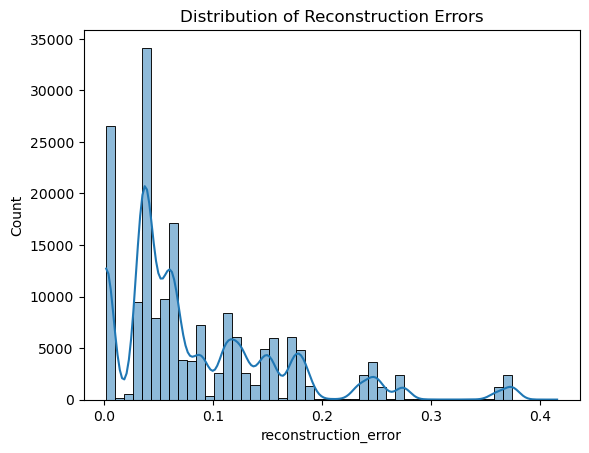

In [47]:
import seaborn as sns
sns.histplot(reconstruction_error_df['reconstruction_error'], bins=50, kde=True)
plt.title('Distribution of Reconstruction Errors')
plt.show()

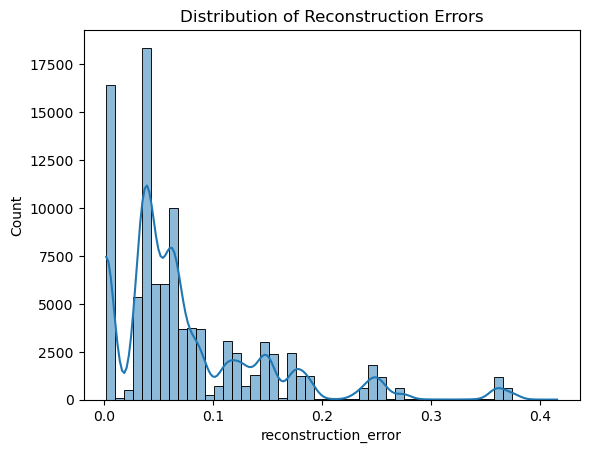

In [11]:
import seaborn as sns
sns.histplot(reconstruction_error_df['reconstruction_error'], bins=50, kde=True)
plt.title('Distribution of Reconstruction Errors')
plt.show() # ill v2 

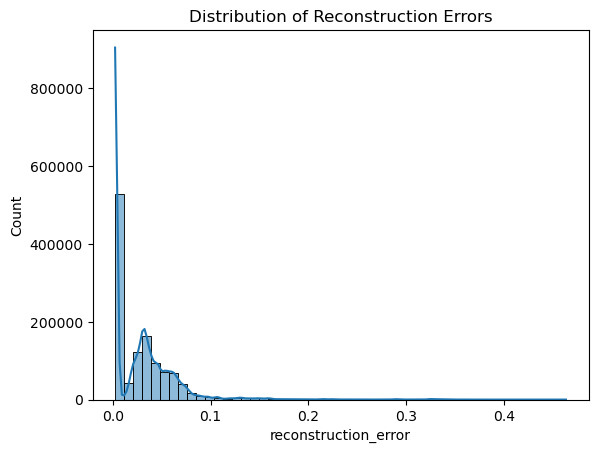

In [10]:
import seaborn as sns
sns.histplot(reconstruction_error_df['reconstruction_error'], bins=50, kde=True)
plt.title('Distribution of Reconstruction Errors')
plt.show() # Reputable

In [ ]:
import seaborn as sns
from sklearn.metrics import precision_recall_curve, average_precision_score
# reconstruction_error = np.mean(np.abs(reconstructions_no_label - X_all_no_label), axis=(1, 2))
reconstruction_error_df = pd.DataFrame({
    'address': all_addresses,
    'reconstruction_error': reconstruction_error,
    'is_reputable': df_reputable['is_reputable']
})
sns.histplot(reconstruction_error_df['reconstruction_error'], bins=50, kde=True)
plt.title('Distribution of Reconstruction Errors')
plt.show()
